# Preamble

## Imports

Standard imports

In [1]:
import sys, os, re, time, copy
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import unidecode

Language libraries:

In [2]:
from textblob import TextBlob

### Settings

Disable copy warnings in Pandas

In [3]:
pd.options.mode.chained_assignment = None  # default='warn'

Disable depreciation warnings

In [4]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

-----
# Step 1: Inspect the data
-----

## Load the data

You can also download the Excel sheet directly by clicking here: [download](https://github.com/TiesdeKok/MAS_2022_textual_analysis/raw/main/facebook_review_dataset.xlsx)

In [5]:
review_df = pd.read_excel('facebook_review_dataset.xlsx')

## Inspect the data

### Dataset

In [6]:
print(f"The dataset contains {len(review_df)} reviews. \nThe oldest review is from {review_df['date'].min()} \nThe newest review is from {review_df['date'].max()}.")
review_df.head(2).T

The dataset contains 2290 reviews. 
The oldest review is from 2014-03-17 00:00:00 
The newest review is from 2021-12-28 00:00:00.


,0,1
date,2021-11-09 00:00:00,2021-12-25 00:00:00
year,2021,2021
rating,5,5
rating_wlb,5,5
rating_culture,5,5
rating_dei,5,4
rating_comp,5,4
job_title,Software Engineer,Data Scientist
location,"Seattle, WA","San Francisco, CA"
pros,"I’m still a bit new, but I have very good impr...","Its all you hear about, fun and diverse and su..."


### Number of reviews by year

In [7]:
review_df.value_counts('year').sort_index(ascending=False)

year
2021    1123
2020     572
2019     226
2018     239
2017     128
2016       1
2014       1
dtype: int64

------
------
## Task 1: Evaluate the textual data that we are working with. 

Things to evaluate:

- What types of constructs could you generate based on the reviews? 

### Show random review

**Note:** Every time you run the code below it will show a different review in the dataset.

In [8]:
#############################
## Run this cell to evaluate!
############################# 

review_row = review_df.sample(1).iloc[0].to_dict()
print(f"Review by a {review_row['job_title']} in {review_row['location']} on {review_row['date']}")
print(f"\nPros: \n\n{review_row['pros'].strip()}")
print(f"\nCons: \n\n{review_row['cons'].strip()}")

Review by a Leasing Agent in San Jose, CA on 2021-01-16 00:00:00

Pros: 

Love the energy around each campus

Cons: 

Poor management skills_x000D_
Poor sick pay


## 

------
------


# Step 2: Clean the data
-----

### Cleaning function

In [9]:
def clean_text(input_str):
    clean_str = copy.copy(input_str)

    ## Remove special characters
    clean_str = unidecode.unidecode(clean_str)

    ## Remove any non-letter characters except for regular sentence-ending punctuation
    clean_str = re.sub(r'[^a-zA-Z\s\.!\?\\n]', '', clean_str)

    ## Replace all \s with a single space except for \n
    clean_str = re.sub(r'[ \t\x0B\f\r]+', ' ', clean_str)

    ## Replace a newline with a dot and a space
    clean_str = re.sub(r'\s*\n\s*', '. ', clean_str)

    ## Replace duplicate dots
    clean_str = re.sub(r'\.+', '.', clean_str)

    ## Remove any leading or trailing spaces
    clean_str = clean_str.strip()

    ## Add trailing dot if not exists
    if clean_str[-1] != '.':
        clean_str += '.'

    return clean_str

### Run

In [10]:
review_df['pros_clean'] = review_df['pros'].apply(clean_text)
review_df['cons_clean'] = review_df['cons'].apply(clean_text)

#### Add lower case version

In [11]:
review_df['pros_clean_l'] = review_df['pros_clean'].str.lower()
review_df['cons_clean_l'] = review_df['cons_clean'].str.lower()

------
------
## Task 2: Evaluate whether we did a good job cleaning the data

Things to evaluate:

- Compare the "dirty" versus the "clean" text (see below), what are the types of things that are different?
- Can you find any remaining errors that aren't taken care off, should we deal with these?

### Inspect

In [12]:
#############################
## Run this cell to evaluate!
############################# 

review_row = review_df.sample(1).iloc[0].to_dict()
print(f"Review by a {review_row['job_title']} in {review_row['location']} on {review_row['date']}")
print(f"\nPros: \n\n{review_row['pros'].strip()}")
print(f"\nPros clean: \n\n{review_row['pros_clean'].strip()}")
print('\n' + '-'*50)
print(f"\nCons: \n\n{review_row['cons'].strip()}")
print(f"\nCons clean: \n\n{review_row['cons_clean'].strip()}")

Review by a Engineering Training Specialist in Menlo Park, CA on 2018-02-03 00:00:00

Pros: 

Facebook really respects its employees and is very interested in diversity and that everyone is treated and compensated fairly. Zuck is a great leader

Pros clean: 

Facebook really respects its employees and is very interested in diversity and that everyone is treated and compensated fairly. Zuck is a great leader.

--------------------------------------------------

Cons: 

The work life balance can be a challenge, but overall Facebook really does care about trying to make this better.

Cons clean: 

The work life balance can be a challenge but overall Facebook really does care about trying to make this better.


------
------
# Step 3: Analyze the data


------
------
## Task 3a: Let's perform a keyword analysis!

Things to evaluate:

- Use the provided keywords to see what we can learn about the reviews.
- Can you come up with keywords of your own to obtain additional insights?

### Check whether each pros and cons contains a keyword

In [13]:
#############################
## Run this to evaluate
############################# 

keywords_of_interest = ['traffic', 'culture', 'salary', 'diversity', 'balance'] ## <-- Change this!

text_types = ['pros', 'cons']
contains_columns = []
for text_type in text_types:
    for keyword in keywords_of_interest:
        review_df[f'{text_type}_contains_{keyword}'] = review_df[f'{text_type}_clean_l'].str.contains(keyword)**1
        contains_columns.append(f'{text_type}_contains_{keyword}')

review_kw_df = review_df[contains_columns].sum().reset_index().rename(columns={'index' : 'group', 0 : 'count'})
tmp_df = review_kw_df['group'].str.split('_', expand=True).rename(columns={0 : 'text_type', 2 : 'keyword'}).drop(1,axis=1)
review_kw_df = pd.concat([review_kw_df, tmp_df], axis=1)
review_kw_df = review_kw_df[['keyword', 'text_type', 'count']].sort_values(by='keyword', ascending=False)

review_kw_df

,keyword,text_type,count
0,traffic,pros,0
5,traffic,cons,9
2,salary,pros,125
7,salary,cons,12
3,diversity,pros,34
8,diversity,cons,28
1,culture,pros,407
6,culture,cons,155
4,balance,pros,118
9,balance,cons,279


## Sentiment analysis

### Add the sentiment to the dataframe

In [14]:
def add_sentiment(input_str):
    return TextBlob(input_str).sentiment.polarity

In [15]:
review_df['pros_sentiment'] = review_df['pros_clean'].apply(add_sentiment)
review_df['cons_sentiment'] = review_df['cons_clean'].apply(add_sentiment)
review_df['average_sentiment'] = (review_df['pros_sentiment'] + review_df['cons_sentiment'])/2

------
------
## Task 4: Inspect the sentiment scores, are they reasonable?

Things to evaluate:

- Use the inspection tools below to evaluate whether the sentiment scores work as expected. Can you find any issues?

### Inspect

In [16]:
#############################
## Run this cell to evaluate!
############################# 

review_row = review_df.sample(1).iloc[0].to_dict()
print(f"Review by a {review_row['job_title']} in {review_row['location']} on {review_row['date']}")
print(f"\nPros clean (sentiment: {review_row['pros_sentiment']:.2f}): \n\n{review_row['pros_clean'].strip()}")
print('\n' + '-'*50)
print(f"\nCons clean (sentiment: {review_row['cons_sentiment']:.2f}): \n\n{review_row['cons_clean'].strip()}")

Review by a Writer in Chicago, IL on 2021-04-23 00:00:00

Pros clean (sentiment: 0.70): 

Good stuff good people good.

--------------------------------------------------

Cons clean (sentiment: 0.00): 

its facebook what do u think.


### Show summary statistics for the sentiment

In [17]:
#############################
## Run this cell to evaluate!
############################# 

review_df[['pros_sentiment', 'cons_sentiment']].describe()

,pros_sentiment,cons_sentiment
count,2290.000000,2290.000000
mean,0.429227,0.046158
std,0.280898,0.279836
min,-1.000000,-1.000000
25%,0.228921,-0.050000
50%,0.450000,0.000000
75%,0.650000,0.200000
max,1.000000,1.000000


### Show examples of high and low sentiment reviews

In [18]:
#############################
## Run this cell to evaluate!
############################# 

top_pos_df = review_df.sort_values(by=['pros_sentiment', 'cons_sentiment'], ascending=False).head(20)
review_row = top_pos_df.sample(1).iloc[0].to_dict()
print(f"Very positive review by a {review_row['job_title']} in {review_row['location']} on {review_row['date']}")
print(f"\nPros clean (sentiment: {review_row['pros_sentiment']:.2f}): \n\n{review_row['pros_clean'].strip()}")
print('\n' + '-'*50)
print(f"\nCons clean (sentiment: {review_row['cons_sentiment']:.2f}): \n\n{review_row['cons_clean'].strip()}")

Very positive review by a Content Designer in Seattle, WA on 2021-07-18 00:00:00

Pros clean (sentiment: 1.00): 

Culture sense of empowerment and responsibility. Flexibility in how you perform your job. Benefits are excellent.

--------------------------------------------------

Cons clean (sentiment: 0.10): 

Fastpaced high expectations biannual intense reviews. Sometimes no clear accountability.


In [19]:
#############################
## Run this cell to evaluate!
############################# 

top_neg_df = review_df.sort_values(by=['pros_sentiment', 'cons_sentiment'], ascending=True).head(20)
review_row = top_neg_df.sample(1).iloc[0].to_dict()
print(f"Very negative review by a {review_row['job_title']} in {review_row['location']} on {review_row['date']}")
print(f"\nPros clean (sentiment: {review_row['pros_sentiment']:.2f}): \n\n{review_row['pros_clean'].strip()}")
print('\n' + '-'*50)
print(f"\nCons clean (sentiment: {review_row['cons_sentiment']:.2f}): \n\n{review_row['cons_clean'].strip()}")

Very negative review by a Software Engineer in San Francisco, CA on 2021-01-10 00:00:00

Pros clean (sentiment: -0.70): 

I like working here. Its not too bad.

--------------------------------------------------

Cons clean (sentiment: 0.20): 

I really dont like PSC season.


### Did the sentiment change over time?

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
## Retina
sns.set(style="whitegrid", font_scale=1.2)

In [21]:
graph_df = review_df[review_df.year >= 2017]

#### Pros

Text(0, 0.5, 'Sentiment')

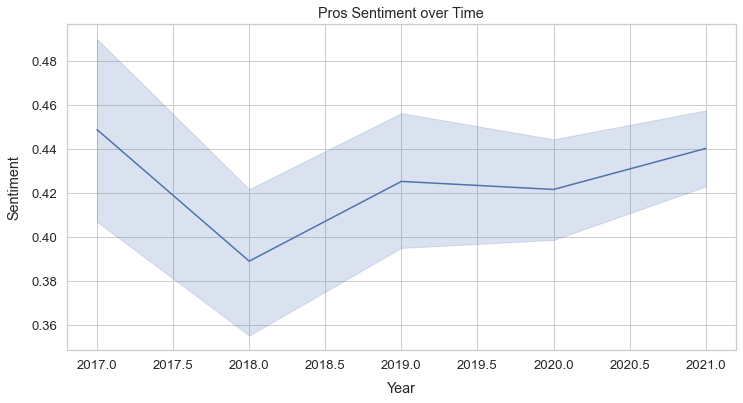

In [22]:
plt.figure(figsize=(12,6))
sns.lineplot(y='pros_sentiment', x='year', data=graph_df)

## make pretty
plt.title('Pros Sentiment over Time')
plt.xlabel('Year', labelpad=10)
plt.ylabel('Sentiment', labelpad=10)

#### Cons

Text(0, 0.5, 'Sentiment')

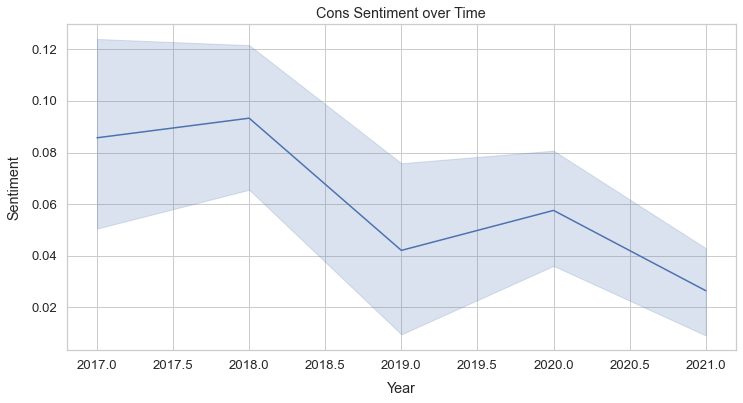

In [23]:
plt.figure(figsize=(12,6))
sns.lineplot(y='cons_sentiment', x='year', data=graph_df)

plt.title('Cons Sentiment over Time')
plt.xlabel('Year', labelpad=10)
plt.ylabel('Sentiment', labelpad=10)

### Does the average yearly sentiment and the average yearly ratings change similarly over time?

#### Text sentiment

Text(0, 0.5, 'Sentiment')

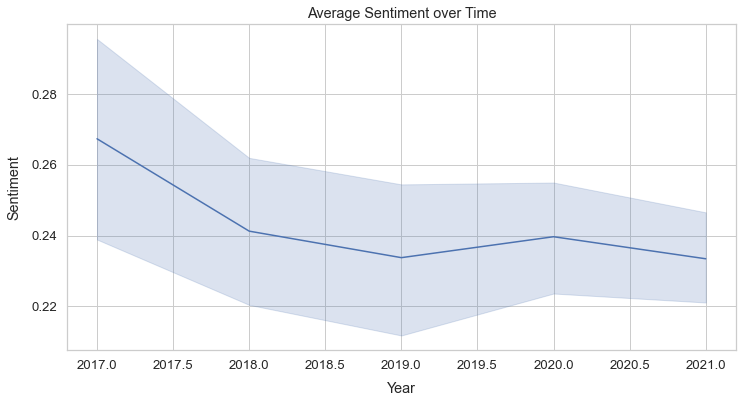

In [24]:
plt.figure(figsize=(12,6))
sns.lineplot(y='average_sentiment', x='year', data=graph_df)

plt.title('Average Sentiment over Time')
plt.xlabel('Year', labelpad=10)
plt.ylabel('Sentiment', labelpad=10)

### Rating sentiment

Text(0, 0.5, 'Rating')

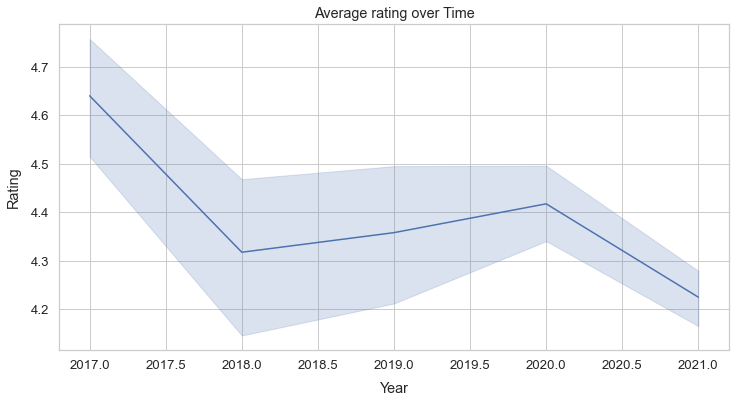

In [25]:
plt.figure(figsize=(12,6))
sns.lineplot(y='rating', x='year', data=graph_df)

plt.title('Average rating over Time')
plt.xlabel('Year', labelpad=10)
plt.ylabel('Rating', labelpad=10)

--------
# Advanced - LDA model
-------

## Prep the data

In [26]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [27]:
clean_pros_l = review_df['pros_clean_l'].tolist()
clean_cons_l = review_df['cons_clean_l'].tolist()

In [28]:
vec_pros = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)
tf_pros = vec_pros.fit_transform(clean_pros_l)

vec_cons = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)
tf_cons = vec_cons.fit_transform(clean_cons_l)

## Train the models

#### Pros

In [29]:
n_topics = 3
lda_pros = LatentDirichletAllocation(n_components=n_topics, max_iter=10,
                                learning_method='online',
                                n_jobs=1)
lda_f_pros = lda_pros.fit_transform(tf_pros)

#### Cons

In [30]:
n_topics = 3
lda_cons = LatentDirichletAllocation(n_components=n_topics, max_iter=10,
                                learning_method='online',
                                n_jobs=1)
lda_f_cons = lda_cons.fit_transform(tf_cons)

## Visualize

In [31]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

## Task 5: LDA Analysis, do the clusters make sense? 

Things to evaluate:

- Use the inspection tools below to evaluate whether the LD&A clusters make sense. Can you interpret what the different clusters represent?
- Play around with the `n_topics` parameter to see how the results change.

### Pros

In [32]:
################
## Evaluate this
################ 

pyLDAvis.sklearn.prepare(lda_pros, tf_pros, vec_pros, n_jobs=1)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.046872 -0.161956       1        1  45.252250
0     -0.229938  0.053407       2        1  27.601159
1      0.183066  0.108549       3        1  27.146590, topic_info=          Term        Freq       Total Category  logprob  loglift
658       good  585.000000  585.000000  Default  30.0000  30.0000
667      great  800.000000  800.000000  Default  29.0000  29.0000
118   benefits  540.000000  540.000000  Default  28.0000  28.0000
609       food  228.000000  228.000000  Default  27.0000  27.0000
1694      work  769.000000  769.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
1404     smart   57.849604  221.171877   Topic3  -4.7392  -0.0372
1694      work   85.080715  769.687859   Topic3  -4.3534  -0.8985
254    company   68.588262  407.920626   Topic3  -4.5689  -0.4790
1700   working   43.898584  158.870192   Topic3  -5.0151   0.0177
1718        xd   39.620457  591.261568   Topic3  -5.1177  -1.3990

[196 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.945982   ability
0         2  0.032620   ability
18        2  0.972870  actually
44        1  0.992768   amazing
44        3  0.005253   amazing
...     ...       ...       ...
1718      1  0.761084        xd
1718      2  0.172512        xd
1718      3  0.067652        xd
1727      1  0.262666     youre
1727      2  0.722331     youre

[278 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

### Cons

In [33]:
################
## Evaluate this
################

pyLDAvis.sklearn.prepare(lda_cons, tf_cons, vec_cons, n_jobs=1)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.093197  0.159345       1        1  45.509368
2     -0.122924 -0.145374       2        1  33.338661
1      0.216122 -0.013971       3        1  21.151971, topic_info=         Term        Freq       Total Category  logprob  loglift
2072     work  547.000000  547.000000  Default  30.0000  30.0000
126   balance  238.000000  238.000000  Default  29.0000  29.0000
1032     life  177.000000  177.000000  Default  28.0000  28.0000
324      cons   94.000000   94.000000  Default  27.0000  27.0000
1068      lot  147.000000  147.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
123       bad   32.883426  135.520745   Topic3  -4.9327   0.1373
1854    teams   27.716466  103.445945   Topic3  -5.1037   0.2364
1195     need   25.265236   84.004086   Topic3  -5.1963   0.3520
387   culture   28.575224  151.142638   Topic3  -5.0732  -0.1122
292   company   25.684151  350.698477   Topic3  -5.1798  -1.0606

[206 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
92        3  0.952994     area
123       1  0.184474      bad
123       2  0.575558      bad
123       3  0.243505      bad
126       3  0.997812  balance
...     ...       ...      ...
2093      2  0.178268       xd
2093      3  0.014454       xd
2104      1  0.427541    youre
2104      2  0.562553    youre
2104      3  0.011251    youre

[276 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])